In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme
import matplotlib.pyplot as plt

In [2]:
HRDF = pd.read_csv('forHR.tsv',sep='\t',header=None)

#'umag','sgmag','srmag','simag','szmag','prob','teff','logh','mass','teff2','logh2','mass2','rai','dei'
HRDF[10].replace('         ', np.nan, inplace=True)
HRDF[11].replace('         ', np.nan, inplace=True)
HRDF[12].replace('         ', np.nan, inplace=True)
HRDF[7].replace('         ', np.nan, inplace=True)
HRDF = HRDF[HRDF[10].notna()]
HRDF = HRDF[HRDF[11].notna()]
HRDF = HRDF[HRDF[12].notna()]
HRDF = HRDF[HRDF[7].notna()]
gmag = HRDF[10].to_numpy()
bpmag = HRDF[11].to_numpy()
rpmag = HRDF[12].to_numpy()
parallax = HRDF[7].to_numpy()
#JJTimes = (JJDF['Time'].to_numpy()/60/60/24)+2459076.6992445
#print(JJDF)

In [3]:
gmag = gmag + 5*(np.log10(parallax/1000)+1)


In [4]:
wd1219GMAG = 17.561228 + 5*(np.log10(14.2774/1000)+1)
wd1252GMAG = 17.477457+ 5*(np.log10(12.9437/1000)+1)

In [5]:
specialStarsy = np.array([13.46,wd1252GMAG,wd1219GMAG,13.10]) # gd, j1252,1219,04
specialStarsx = np.array([0.388,17.582787-17.189125,17.673635-17.231398,0.287])

popx = bpmag-rpmag
popy = gmag

In [6]:
def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p

In [7]:
def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d

In [8]:
def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot

In [9]:
def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [12]:
ks2d2s(specialStarsx, specialStarsy, popx,popy,extra=True)

(0.00341473730148067, 0.8100488893612499)

In [24]:
ks2d2s(popx,popy,specialStarsx, specialStarsy,extra=True)

(0.00341473730148067, 0.8100488893612499)

In [13]:
ks2d2s(popx[:100], popy[:100], popx,popy,extra=True)

(0.00011023600111481841, 0.24898288872356247)

In [14]:
ks2d2s(popx[:10], popy[:10], popx,popy,extra=True)

(0.20135043069081018, 0.3417260070145605)

In [15]:
ks2d2s(popx[:1000], popy[:1000], popx,popy,extra=True)

(3.1912927284601143e-91, 0.3773836752045914)

In [16]:
ks2d2s(popx[:5], popy[:5], popx,popy,extra=True)

(0.5473243766912361, 0.3426772239345308)

In [17]:
ks2d2s(popx[:500], popy[:500], popx,popy,extra=True)

(1.6753829437898833e-49, 0.39047061324264004)

In [18]:
estat2d(specialStarsx, specialStarsy, popx,popy)

D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


KeyboardInterrupt: 

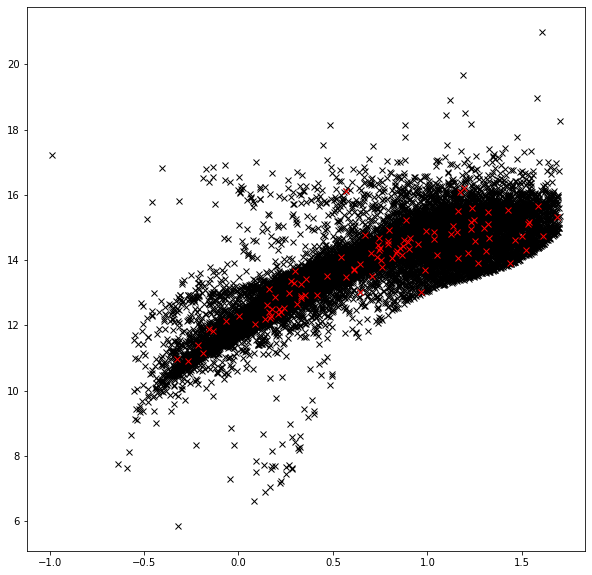

In [29]:
plt.figure(figsize=(10,10))

plt.plot(popx, popy,'kx')
index = np.random.randint(low=0, high=len(popx), size=100)
plt.plot(popx[index], popy[index],'rx')

In [32]:
averagesM = []
statisticM = []
for i in range(100):
    index = np.random.randint(low=0, high=len(popx), size=100)
    avg, stat = ks2d2s(popx[index], popy[index], popx,popy,extra=True)
    averagesM.append(avg)
    statisticM.append(stat)

Text(0, 0.5, 'frequency')

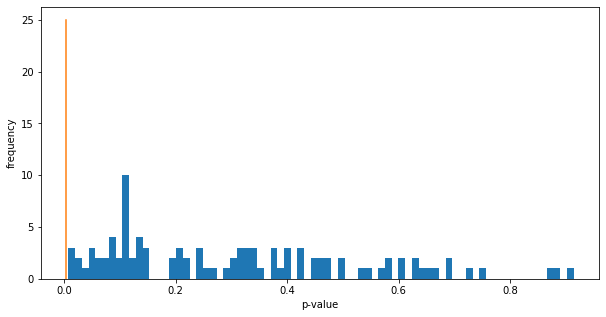

In [33]:
plt.figure(figsize=(10,5))
plt.hist(averagesM, bins=75)
plt.plot([0.00341473730148067,0.00341473730148067],[0,25])
plt.xlabel('p-value')
plt.ylabel('frequency')

Text(0.5, 0, 'statistic')

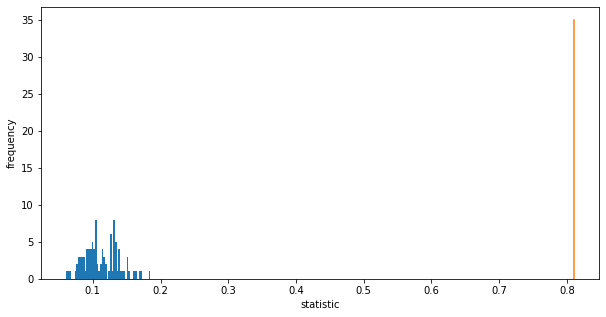

In [34]:
plt.figure(figsize=(10,5))
plt.hist(statisticM, bins=50)
plt.plot([0.8100488893612499,0.8100488893612499],[0,35])
plt.ylabel('frequency')
plt.xlabel('statistic')

In [10]:
averages = []
statistic = []
for i in range(500):
    index = np.random.randint(low=0, high=len(popx), size=4)
    avg, stat = ks2d2s(popx[index], popy[index], popx,popy,extra=True)
    averages.append(avg)
    statistic.append(stat)

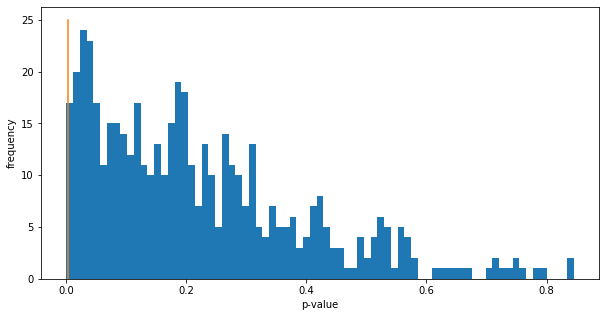

In [31]:
plt.figure(figsize=(10,5))
plt.hist(averages, bins=75)
plt.plot([0.00341473730148067,0.00341473730148067],[0,25])
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.savefig('pVal2DKS.pdf')

In [36]:
for el in averages:
    if el < 0.00341473730148067:
        print('ay')

ay
ay
ay
ay
ay
ay


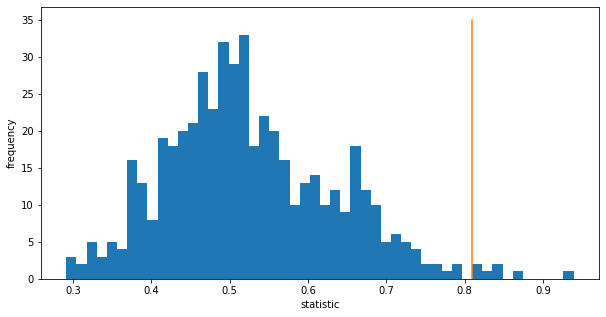

In [30]:
plt.figure(figsize=(10,5))
plt.hist(statistic, bins=50)
plt.plot([0.8100488893612499,0.8100488893612499],[0,35])
plt.ylabel('frequency')
plt.xlabel('statistic')
plt.savefig('Stat2DKS.pdf')

In [37]:
np.save('statistic4.npy', statistic)
np.save('averages4.npy', averages)
np.save('statistic100.npy', statisticM)
np.save('averages100.npy', averagesM)

In [20]:
ks2d2s(np.array([0,0.1,0.2,0.1]), np.array([8,8.1,7.9,8]), popx,popy,extra=True)

(0.00037946569627792263, 0.9410404931448613)

In [38]:
min(averages)

0.00388624847903559

In [44]:
0.00341473730148067, 0.8100488893612499

(0.00341473730148067, 0.8100488893612499)

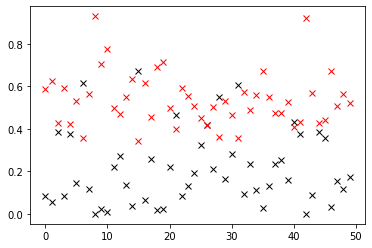

In [46]:
plt.plot(averages, 'kx')
plt.plot(statistic,'rx')